# DaqDataClient

This section demonstrates how to use the synchronous (blocking) `DaqDataClient` API.

In [1]:
from pathlib import Path
import json
from rich import print
import rich.jupyter
import logging

from daq_data.client import DaqDataClient
from daq_data.plot import PanoImagePreviewer, PulseHeightDistribution

%load_ext autoreload
%autoreload 2

In [2]:
# Configure paths
cfg_dir = Path('daq_data/config')

daq_config_path = cfg_dir / 'daq_config_grpc_simulate.json'
network_config_path = cfg_dir / 'network_config_grpc_simulate.json'
hp_io_config_path = cfg_dir / 'hp_io_config_simulate.json'

# Load configuration files
with open(daq_config_path, 'r') as f:
    daq_config = json.load(f)

with open(network_config_path, 'r') as f:
    network_config = json.load(f)
    
with open(hp_io_config_path, 'r') as f:
    hp_io_config = json.load(f)

# Override the default HTML format to remove the bottom margin from <pre> tags.
rich.jupyter.JUPYTER_HTML_FORMAT = """
<pre style="white-space: pre; overflow-x: auto; margin: 0; padding: 0.1em; line-height: 1.2;">{code}</pre>
"""

## Minimal StreamImages Client

In [8]:
with DaqDataClient(daq_config, network_config) as client:
    # 1. Get valid hosts
    valid_hosts = client.get_valid_daq_hosts()
    if not valid_hosts:
        raise RuntimeError("No valid DAQ hosts found.")
    print(client.get_daq_host_status())

    # 2. Initialize servers in simulation mode
    all_init_success = client.init_sim(hosts=[])
    if not all_init_success:
        raise RuntimeError("Failed to initialize one or more servers.")
    print("All servers initialized for simulation.")

    # 3. Stream pulse-height and movie data from all modules
    image_stream = client.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        module_ids=()
    )

    # 4. Listen to the stream and process data
    print("Starting data stream. Press Ctrl+C to stop.")
    for image_data in image_stream:
        # In a real application, you would pass this data to a
        # visualization or analysis function.
        print(
            f"Image: Module {image_data['module_id']}, "
            f"Type: {image_data['type']}, "
            f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
        )

18:54:47 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

{'10.0.0.60:50051': True, 'localhost:50051': False}

         INFO     [init_hp_io()] Initializing hp_io on '10.0.0.60:50051'...

18:54:50 INFO     [init_hp_io()] host='10.0.0.60': init_hp_io_response.success=True

All servers initialized for simulation.

         INFO     [stream_images()] stream_images_request={'stream_movie_data': True, 'stream_pulse_height_data':  
                  True, 'update_interval_seconds': 1.0, 'module_ids': []}

         INFO     [stream_images()] Created StreamImages RPC to host='10.0.0.60'

Starting data stream. Press Ctrl+C to stop.

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:07.273442825

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.752007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:10.858415919

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.772007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:13.182558838

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.792007488

## Visualization Clients

### Initialize Simulation Streaming 
For debugging and demonstration, we will start the servers in simulation streaming mode.

In [9]:
with DaqDataClient(daq_config_path, network_config_path) as ddc:

    # Check if any hosts are valid
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")

    # Initialize the server
    all_init_success = ddc.init_sim([])
    print(f"{all_init_success=}")

18:55:01 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

         INFO     [init_hp_io()] Initializing hp_io on '10.0.0.60:50051'...

18:55:03 INFO     [init_hp_io()] host='10.0.0.60': init_hp_io_response.success=True

all_init_success=True

### Streaming from One DAQ node

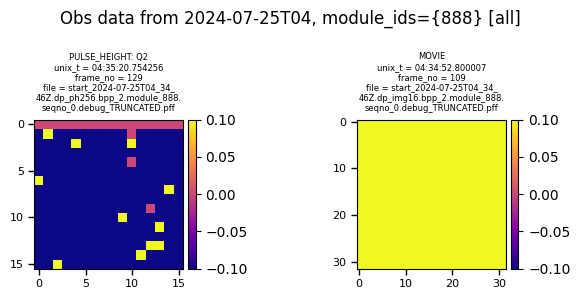

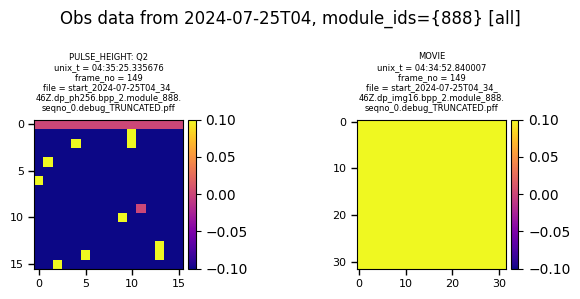

In [11]:
# Show PanoImagePreviewer: One DAQ node

with DaqDataClient(daq_config, network_config_path) as ddc:

    # Initialize simulation
    all_success = ddc.init_sim([])
    
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        # module_id_whitelist=[],
        jupyter_notebook=True
    )

    # Get first valid daq node
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    host = list(valid_daq_hosts)[0] 
    
    # Call the StreamImages RPC on one valid DAQ node
    pano_image_stream = ddc.stream_images(
        host,
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update visualization
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

### Streaming from Multiple DAQ Nodes

Streaming from multiple DAQ nodes is no harder than streaming from a single DAQ node.

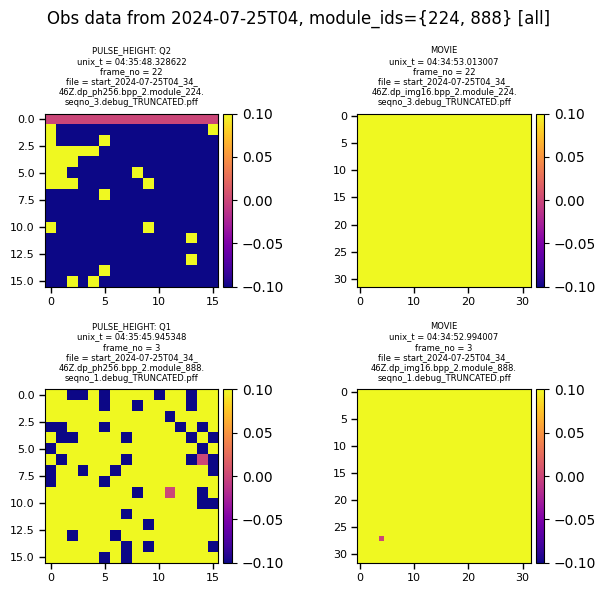

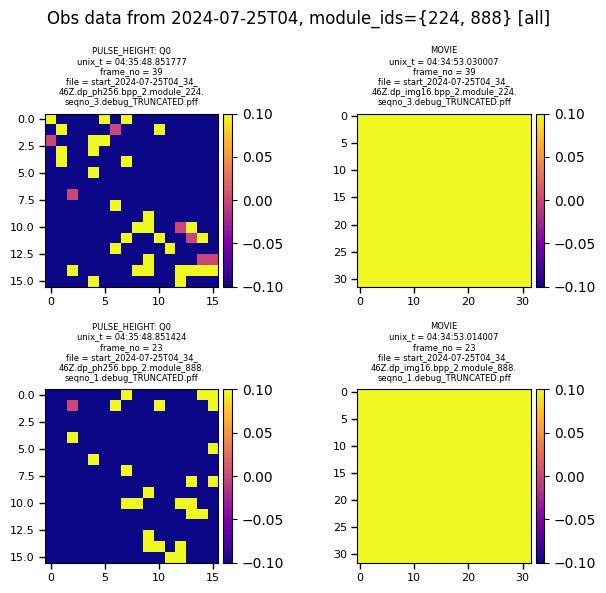

In [14]:
# Show PanoImagePreviewer: Multiple DAQ nodes

# 1. Connect to all DAQ nodes
with DaqDataClient(daq_config_path, network_config_path) as ddc:
    
    # 2. Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        module_id_whitelist=[],
        jupyter_notebook=True
    )
    
    # 3. Call the StreamImages RPC on all valid DAQ nodes
    pano_image_stream = ddc.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=0.25,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # 4. Update visualization for each pano_image
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

# AioDaqDataClient

This section demonstrates how to use the asynchronous (non-blocking) `AioDaqDataClient` API.

## Minimal `AioDaqDataClient`

In [17]:
import asyncio
import logging
from pathlib import Path
from daq_data.client import AioDaqDataClient

# --- Configuration ---
cfg_dir = Path('daq_data/config')
daq_config_path = cfg_dir / 'daq_config_grpc_simulate.json'
network_config_path = cfg_dir / 'network_config_grpc_simulate.json'

async def main():
    """Main function to demonstrate the async client."""
    # Use the client as an asynchronous context manager
    async with AioDaqDataClient(daq_config_path, network_config_path, log_level=logging.INFO) as client:
        
        # 1. Get valid hosts
        valid_hosts = client.get_valid_daq_hosts()
        if not valid_hosts:
            print("No valid DAQ hosts found.")
            return
        print(f"Connected to: {valid_hosts}")

        # 2. Asynchronously initialize servers in simulation mode
        # The underlying RPC calls for each host will run concurrently.
        print("Initializing servers for simulation...")
        all_init_success = await client.init_sim(valid_hosts)
        if not all_init_success:
            print("Failed to initialize one or more servers.")
            return
        print("All servers initialized successfully.")

        # 3. Stream data using 'async for'
        print("\nStarting data stream. Press Ctrl+C to stop.")
        try:
            image_stream = await client.stream_images(
                hosts=valid_hosts,
                stream_movie_data=True,
                stream_pulse_height_data=True,
                update_interval_seconds=1.0,
            )
            
            # Iterate over the async generator
            async for image_data in image_stream:
                print(
                    f"Image: Module {image_data['module_id']}, "
                    f"Type: {image_data['type']}, "
                    f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
                )
        except asyncio.CancelledError:
            print("\nStream cancelled.")
        except grpc.aio.AioRpcError as e:
            print(f"\nStream failed with RPC error: {e}")

if __name__ == "__main__":
    try:
        # Jupyter notebooks have their own event loop, so we can schedule our task onto it.
        loop = asyncio.get_event_loop()
        main_task = loop.create_task(main())
        await main_task
    except KeyboardInterrupt:
        print("\nExiting.")

Connected to: {'localhost', '10.0.0.60'}

Initializing servers for simulation...

18:25:40 INFO     [_init_single_host()] Initializing hp_io on localhost...

         INFO     [_init_single_host()] Initializing hp_io on 10.0.0.60...

18:25:42 INFO     [_init_single_host()] host='localhost': init_hp_io_response.success=True

         INFO     [_init_single_host()] host='10.0.0.60': init_hp_io_response.success=True

All servers initialized successfully.

Starting data stream. Press Ctrl+C to stop.

         INFO     [stream_images()] Created 2 StreamImages RPCs to hosts: {'localhost', '10.0.0.60'}

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:03.000446935

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.735007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:03.467969177

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.739007488

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:08.058918925

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.755007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:08.059024403

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.759007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:11.949926960

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.779007488

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:10.858549334

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.773007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:15.544696610

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.799007488

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:13.323218022

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.793007488

Stream cancelled.

### 

In [ ]:
if __name__ == "__main__":
    try:
        # Jupyter notebooks have their own event loop, so we can schedule our task onto it.
        loop = asyncio.get_event_loop()
        main_task = loop.create_task(main())
        await main_task
    except KeyboardInterrupt:
        print("\nExiting.")